# Exemplary end-to-end causal analysis with cause2e
This notebook shows an example of how cause2e can be used as a standalone package for end-to-end causal analysis. It illustrates how we can proceed in stringing together many causal techniques that have previously required fitting together various algorithms from separate sources with unclear interfaces. Hopefully, you will find this notebook helpful in guiding you through the process of setting up your own causal analyses for custom problems. The overall structure should always be the same regardless of the application domain. Some of cause2e's functionality is only hinted at and will be explained more thoroughly in subsequent notebooks.

### Imports
By the end of this notebook, you will probably be pleasantly surprised by the fact that we did not have to import lots of different packages to perform a complex analysis consisting of many different subtasks.

In [1]:
import os
from numpy.random import seed
from cause2e import path_mgr, data_generator, knowledge, discovery, estimator

## Set up paths to data and output directories
This step is conveniently handled by the PathManager class, which avoids having to wrestle with paths throughout the multistep causal analysis. If we want to perform the analysis in a directory 'dirname' that contains 'dirname/data' and 'dirname/output' as subdirectories, we can also use PathManagerQuick for an even easier setup. The experiment name is used for generating output files with meaningful names, in case we want to study multiple scenarios (e.g. with varying model parameters).

In [2]:
cwd = os.getcwd()
wd = os.path.dirname(cwd)
paths = path_mgr.PathManagerQuick(experiment_name='linear_test',
                                  data_name='linear_test.csv',
                                  directory=wd
                                  )

## Generate data
For checking if our algorithms can recover known causal graphs and effects, it can be helpful to use synthetic data. This data generator is based on a class from the DoWhy package. Setting the seed only serves the purpose of providing consistent results over several runs of this notebook. Feel free to change it and experiment with the different outcomes!

In [3]:
seed(4)
generator = data_generator.DataGenerator(paths)
generator.generate_linear_dataset(beta=2,
                                  n_common_causes=4,
                                  nrows=25000
                                  )

In this example, we want to estimate the causal effect that a variable v0 has on another variable y. Note that we have prescribed the causal effect to be beta=2. There are 4 common causes acting as confounders. In causal inference, it can be very helpful to visualize these assumptions in a causal graph.

True causal graph:



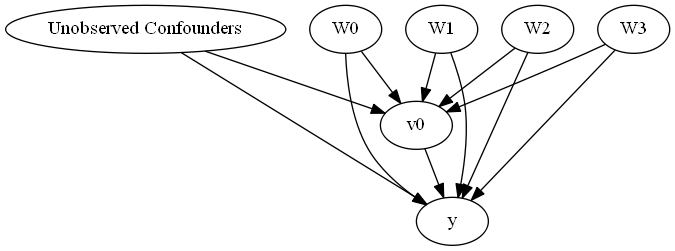

In [4]:
generator.display_graph()

In order to imitate in the remainder of the notebook how we would analyze real-world data, the data is written to a csv file.

In [5]:
generator.write_csv()

## Learn the causal graph from data and domain knowledge
Model-based causal inference leverages qualitative knowledge about pairwise causal connections to obtain unbiased estimates of quantitative causal effects. The qualitative knowledge is encoded in the causal graph, so we must recover this graph before we can start actually estimating the desired effect. For learning the graph from data and domain knowledge, we use the StructureLearner class. Note that we can reuse the PathManager from before to set the right paths.

In [6]:
learner = discovery.StructureLearner(paths)

### Read the data
The StructureLearner has reading methods for csv and parquet files.

In [7]:
learner.read_csv(index_col=0)

Supposing that we had not generated the data ourselves, the first step in the analysis should be an assessment of which variables we are dealing with.

In [8]:
learner.variables

{'W0', 'W1', 'W2', 'W3', 'v0', 'y'}

### Preprocess the data
The raw data is often not suited as immediate input to machine learning algorithms, so we provide some preprocessing facilities: Adding, deleting, renaming and recombining variables is possible. In this example, we demonstrate the possibility to rename some variables, which is necessary to meet the naming constraints of the internally used py-causal package.

In [9]:
name_change = {'v0': 'v',
               'W0': 'W_zero',
               'W1': 'W_one',
               'W2': 'W_two',
               'W3': 'W_three'
               }
for current_name, new_name in name_change.items():
    learner.rename_variable(current_name, new_name)

Once we have our data in the final form, it will be necessary to communicate to the StructureLearner if the variables are discrete, continuous, or both. We check how many unique values each variable takes on in our sample and deduce that all variables except for v are continuous.

In [10]:
learner.data.nunique()

W_zero     25000
W_one      25000
W_two      25000
W_three    25000
v              2
y          25000
dtype: int64

This information is passed to the StructureLearner by indicating the exact sets of discrete and continuous variables.

In [11]:
learner.discrete = {'v'}
learner.continuous = set(learner.data.columns) - {'v'}

### Provide domain knowledge
Humans can often infer parts of the causal graph from domain knowledge. The nodes are always just the variables in the data, so the problem of finding the right graph comes down to selecting the right edges between them.
There are three ways of passing domain knowledge:
- Indicate which edges must be present in the causal graph.
- Indicate which edges must not be present in the causal graph.
- Indicate a temporal order in which the variables have been created. This is then used to generate forbidden edges, since the future can never influence the past.

In our first attempt to recover the graph from data and domain knowledge, we only assume that y is directly influenced by v. 

In [12]:
required = {('v', 'y')}

We pass the knowledge to the StructureLearner and check if it has been correctly received.

In [13]:
learner.set_knowledge(required=required)
learner.knowledge

{'forbidden': set(), 'required': {('v', 'y')}, 'temporal': []}

### Select a structure learning algorithm
Now that the StructureLearner has received the data and the domain knowledge, we can try to recover the original graph using causal discovery methods provided by the internally called py-causal package. There are many parameters that can be tuned (choice of algorithm, search score, independence test, hyperparameters, ...) and we can get an overview by calling some informative methods of the learner. Reasonable default arguments are provided, so you can skip this section at a quick reading.

In [14]:
learner.show_search_algos()
learner.show_search_scores()
learner.show_independence_tests()

TETRAD search algos:

fas
fask
fci
fges
fges-mb
fofc
ftfc
gfci
glasso
imgs_cont
imgs_disc
ling
lingam
mbfs
mgm
multi-fask
pc-all
r-skew
r3
rfci
rfci-bsc
skew
ts-fci
ts-gfci
ts-imgs
---------------------

TETRAD search scores:

bdeu-score
cci-score
cg-bic-score
cg-other-bic-score
d-sep-score
degen-gauss-bic
disc-bic-score
disc-mixed-bic-score
mnlr-bic-score
mvp-bic-score
sem-bic
---------------------

TETRAD search independence tests:

bdeu-test
cci-test
cg-lr-test
chi-square-test
d-sep-test
dg-lr-test
disc-bic-test
fisher-z-test
g-square-test
kci-test
mnlrlr-test
mvplr-test
prob-test
---------------------



To make an informed choice, we can browse through the proposed search algorithms and decide which one fits our problem. Let us have a look at the FGES algorithm, which is a well known score-based algorithm that is suitable for our mix of continuous and discrete data. Note that it also accepts domain knowledge.

In [15]:
learner.show_algo_info('fges')

FGES is an optimized and parallelized version of an algorithm developed by Meek [Meek, 1997] called the Greedy Equivalence Search (GES). The algorithm was further developed and studied by Chickering [Chickering, 2002]. GES is a Bayesian algorithm that heuristically searches the space of CBNs and returns the model with highest Bayesian score it finds. In particular, GES starts its search with the empty graph. It then performs a forward stepping search in which edges are added between nodes in order to increase the Bayesian score. This process continues until no single edge addition increases the score. Finally, it performs a backward stepping search that removes edges until no single edge removal can increase the score. More information is available here and here. The reference is Ramsey et al., 2017.
The algorithms requires a decomposable score—that is, a score that for the entire DAG model is a sum of logged scores of each variables given its parents in the model. The algorithms can t

If we actually want to call the algorithm, we need to know if it requires additional hyperparameters and what they mean. These can be inspected via another utility method.

In [16]:
learner.show_algo_params('fges', score_name='sem-bic')

faithfulnessAssumed: This is a parameter for FGES (“Fast GES”). If this is set to ‘Yes’, it will be assumed that if X _||_ Y, by an independence test, then X _||_ Y | Z for nonempty Z. If the model is faithful to the data, this will necessarily be the case. However, there are some non-faithful examples one can propose where this is not the case. If one is worried about this kind of unfaithfulness, one should set this parameter to ‘No’. If one is willing to tolerate this kind of unfaithfulness, then setting this parameter to ‘Yes’ leads to significantly faster searches. (java.lang.Boolean) [default:true]
symmetricFirstStep: For discrete searches, and in some other situations, it may make a difference for an edge X—Y whether you score X->Y or X<-Y, even though theoretically they should have the same score. If this parameter is set to “Yes”, both scores will be calculated and the higher score used. (Recall we are calculating BIC as 2L – c k ln N, where c is the penalty discount.) (java.la

In order to spare users from the pain of going through all the above reading whenever they want to perform just a quick exploratory analysis, we have provided default arguments (FGES with SEM-BIC score for possibly mixed datatypes and respecting domain knowledge) that let you start the search without any finetuning. Just call run_search() and you are good to go.

### Apply the selected structure learning algorithm
The output of the search is a proposed causal graph. We can ignore the warning about stopping the Java Virtual Machine (needed by py-causal which is a wrapper around the TETRAD software that is written in Java) if we do not run into any problems. If the algorithm cannot orient all edges, we need to do this manually. Therefore, the output includes a list of all undirected edges, so we do not miss them in complicated graphs with many variables and edges.

Remember to stop the JVM after you are completely done.
Proposed causal graph:

The following edges are undirected:

v --- W_three
W_zero --- v
W_two --- v


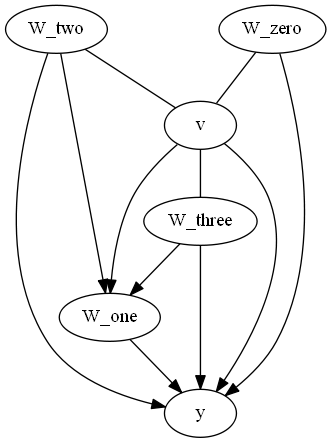

In [17]:
learner.run_search()

Are we done after some calls to learner.add_edge()? No! If we compare the output of the search algorithm to the true causal graph that was used for generating the data, we see that it is not right.
This can happen for several reasons:
- Insufficient data
- Bad choice of search algorithm, hyperparameters, ...
- Several Markov-equivalent graphs fit the data equally well

If we cannot get more data and we have no way of choosing a better search algorithm, the key to good search results is passing comprehensive domain knowledge. This is especially helpful for the problem of choosing between equivalent graphs that are impossible to distinguish using purely statistical methods without domain knowledge.
As a quick check, let us see what happens if we do not pass any domain knowledge.

In [18]:
learner.erase_knowledge()
learner.knowledge

The graph is the same as above, meaning that our sparse domain knowledge about only the edge from v to y was basically worthless.

Remember to stop the JVM after you are completely done.
Proposed causal graph:

The following edges are undirected:

v --- W_three
W_zero --- v
W_two --- v


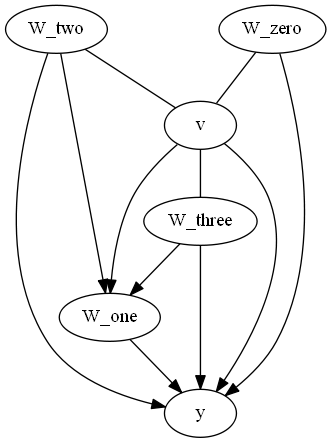

In [19]:
learner.run_search()

Now, let us see if we can come closer to the true causal graph by nurturing our search algorithm with more valuable domain knowledge. Suppose that we know that the confounders themselves are not influenced by any variables. This short and compact sentence contains a lot of constraints on the edges in the graph, as you can see from the output of the next code cell. In principle, we could have passed the set of forbidden edges explicitly after manually enumerating them, but it is often more convenient to directly reason about groups of variables, as is illustrated in the code.

In [20]:
edge_creator = knowledge.ForbiddenEdgeCreator()
w_group = {'W_zero', 'W_one', 'W_two', 'W_three'}
edge_creator.forbid_edges_from_groups(w_group,
                                      no_inf_on_group=learner.variables
                                      )
forbidden = edge_creator.forbidden_edges
required = {('v', 'y')}
learner.set_knowledge(forbidden=forbidden, required=required)
learner.knowledge

{'forbidden': {('W_one', 'W_one'),
  ('W_one', 'W_three'),
  ('W_one', 'W_two'),
  ('W_one', 'W_zero'),
  ('W_three', 'W_one'),
  ('W_three', 'W_three'),
  ('W_three', 'W_two'),
  ('W_three', 'W_zero'),
  ('W_two', 'W_one'),
  ('W_two', 'W_three'),
  ('W_two', 'W_two'),
  ('W_two', 'W_zero'),
  ('W_zero', 'W_one'),
  ('W_zero', 'W_three'),
  ('W_zero', 'W_two'),
  ('W_zero', 'W_zero'),
  ('v', 'W_one'),
  ('v', 'W_three'),
  ('v', 'W_two'),
  ('v', 'W_zero'),
  ('y', 'W_one'),
  ('y', 'W_three'),
  ('y', 'W_two'),
  ('y', 'W_zero')},
 'required': {('v', 'y')},
 'temporal': []}

Repeating the search with the additional domain knowledge gives a causal graph that is already very close to the true graph, showing the importance of explicitly using our knowledge in the search process.

Remember to stop the JVM after you are completely done.
Proposed causal graph:

The following edges are undirected:



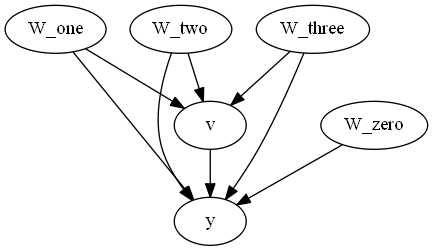

In [21]:
learner.run_search()

### Manually postprocess the graph
It often happens that some edges (present or absent) in the resulting graph feel "odd" and we want to change them manually and compare the results. The possible postprocessing operations are adding, removing and reversing edges.

\[Note: If there is one edge that absolutely should not (or absolutely should) be present in the graph, please consider adding it to the domain knowledge prior to starting the search, instead of making the search unnecessarily hard for the algorithm.\]

In our case, we might find it weird that all the W variables except for W_zero have edges into both v and y, so let us add the "missing" edge.


Proposed causal graph:

The following edges are undirected:



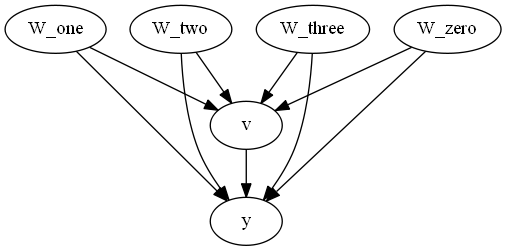

In [22]:
learner.add_edge('W_zero', 'v')

### Saving the graph
Cause2e allows us to save the result of our search to different file formats. The name of the file is determined by the experiment_name parameter from the PathManager.

In [23]:
learner.save_graphs(['dot', 'png', 'svg'])

Saving dot file.
Knowledge is respected!
Saving png file.
Knowledge is respected!
Saving svg file.
Knowledge is respected!


It is worth noting that the saving procedure includes checking that the graph
- is fully directed
- does not contain any cycles
- respects our domain knowledge

This ensures that it can be used in the further causal analysis without any unwanted problems. Just to see this check in action, we add an edge that creates a cycle.

Proposed causal graph:

The following edges are undirected:



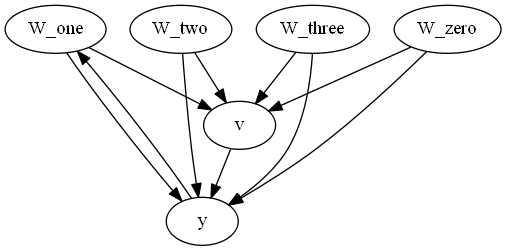

In [24]:
learner.add_edge('y', 'W_one')

When trying to save now, we get an error (that should arguably have a more informative error message) because the graph is not acyclic.

In [25]:
learner.save_graphs(['dot', 'png', 'svg'])

Saving dot file.


AssertionError: 

You can also check these conditions explicitly outside of a saving attempt. This time, we get a message that one of the edges conflicts with our domain knowledge.

In [26]:
learner.is_acyclic()
learner.has_undirected_edges()
learner.respects_knowledge()

AssertionError: Forbidden edges: {('y', 'W_one')}

If we are not interested in feeding the search result into other algorithms for further causal analysis, but rather in just recording what the search procedure has delivered, we can also switch off the checks.

In [27]:
learner.save_graphs(['dot', 'png', 'svg'], strict=False)

Saving dot file.
Saving png file.
Saving svg file.


We end this excursion by removing the faulty edge and restoring the true causal graph.

Proposed causal graph:

The following edges are undirected:



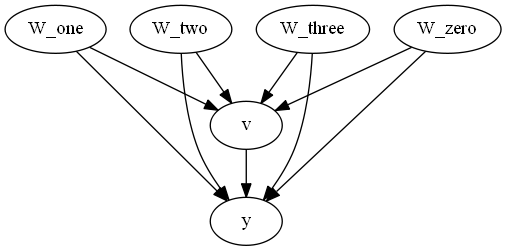

Saving dot file.
Knowledge is respected!
Saving png file.
Knowledge is respected!
Saving svg file.
Knowledge is respected!


In [28]:
learner.remove_edge('y', 'W_one')
learner.save_graphs(['dot', 'png', 'svg'])

## Estimate causal effects from the graph and the data
After we have successfully recovered the causal graph from data and domain knowledge, we can use it to estimate quantitative causal effects between the variables in the graph. It is pleasant that we can use the same graph and data to estimate multiple causal effects, e.g. the one that v has and y, as well as the one that W_one has on v, without having to repeat the previous steps. Once we have managed to qualitatively model the data generating process, we are already in a very good position. The remaining challenges can be tackled with the core functionality from the DoWhy package and some helper methods that make the transition from learning the graph to using it for estimation less cumbersome.

### Create an Estimator
The Estimator class is mainly a wrapper around methods of the DoWhy package. It helps us in performing a principled and modular estimation of causal effects from data and a given causal graph. An exemplary added feature is the possibility to pass a list of transformations that the StructureLearner has applied in preprocessing the data, which makes it easy to cast your data into the same form for estimation.

In [29]:
estim = estimator.Estimator(paths,
                            learner.transformations
                            )

### Read the data
Just like the StructureLearner, the Estimator also has methods for reading data. Having two independent reading steps instead of passing the data directly comes in handy when we want to use different sample sizes for causal discovery and estimation, when we are dealing with big data that cannot be fully stored in RAM, or when we are dealing with two entirely different datasets that only have the qualitative graph structure in common.

In [30]:
estim.read_csv(nrows=7000, index_col=0)

### Imitate preprocessing steps
With our built-in method, it is effortless to get the data in the same format that the causal graph is referring to. In our example, this just means that some variables will be renamed, but the principle stays the same for more involved preprocessing pipelines.

In [31]:
estim.imitate_data_trafos()

### Initialize the causal model
This is the step where we decide which specific effect we want to analyze. We are interested in estimating the effect of v on y. DoWhy conveniently lets us choose between different types of causal effects (overall average treatment effect vs. more specific direct and indirect treatment effects in a mediation analysis).

In [32]:
treatment = 'v'
outcome = 'y'
estim.initialize_model(treatment,
                       outcome,
                       estimand_type="nonparametric-ate"
                       )

### Identify estimands for the causal effect
The big advantage of model-based causal inference is that once we have the causal graph, a statistical estimand for a specified causal effect (e.g. v on y) can be derived by purely algebraic methods (Pearl's do-calculus). The estimand (verbally translated: "the thing that is to be estimated") does not tell us in numbers what the causal effect is, but it is more like an algebraic recipe for estimating the quantity of interest. In our case, the do-calculus tells us that a certain type of backdoor adjustment is the way to go, and the key assumptions for drawing this conclusion are explicitly stated right after a mathematical expression of the estimand. Depending on the graph structure, instrumental variable or frontdoor adjustment strategies can also work, but in this case no valid estimand can be derived using these strategies. The sole argument of the method serves to silence DoWhy's prompting of a user input that must be answered with 'yes' anyway and causes problems in non-interactive development settings.

In [33]:
estim.identify_estimand(proceed_when_unidentifiable=True)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                             
────(Expectation(y|W_two,W_three,W_zero,W_one))
d[v]                                           
Estimand assumption 1, Unconfoundedness: If U→{v} and U→y then P(y|v,W_two,W_three,W_zero,W_one,U) = P(y|v,W_two,W_three,W_zero,W_one)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



### Estimate the causal effect
Now that we know what to estimate, we can focus on the how. For this example, we demonstrate the use of a simple linear regression estimator, but there are many more possibilities documented in [this notebook](https://microsoft.github.io/dowhy/example_notebooks/dowhy_estimation_methods.html) provided by the creators of DoWhy. Using the estimand from the last step, the package knows which covariates should be included as inputs of the linear regression. The result shows that the estimate is very close to the true value of the causal effect (beta=2). The additional output summarizes all decisions that we have taken in order to arrive at this value.

In [34]:
estim.estimate_effect(verbose=True,
                      method_name='backdoor.linear_regression'
                      )

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                             
────(Expectation(y|W_two,W_three,W_zero,W_one))
d[v]                                           
Estimand assumption 1, Unconfoundedness: If U→{v} and U→y then P(y|v,W_two,W_three,W_zero,W_one,U) = P(y|v,W_two,W_three,W_zero,W_one)

## Realized estimand
b: y~v+W_two+W_three+W_zero+W_one
Target units: ate

## Estimate
Mean value: 2.000014249637469



### Perform robustness checks
After we have estimated the causal effect, performing robustness checks can lend additional credibility to our final estimate. DoWhy provides several such checks called 'refuters' that are explained [here](https://microsoft.github.io/dowhy/readme.html#iv-refute-the-obtained-estimate). As an example, we check that the estimate is robust to adding an independent random variable as a common cause to the dataset.

In [35]:
estim.check_robustness(verbose=True,
                       method_name='random_common_cause'
                       )

Refute: Add a Random Common Cause
Estimated effect:2.000014249637469
New effect:2.0000117539530398



### Compare the result to a non-causal regression analysis
Without the causal framework, causal effects are often estimated by running a linear regression with the outcome (y) as target variable and the treatment (v) and possibly other covariates as input variables. The causal effect is then assumed to be the coefficient associated with the treatment variable in the resulting regression equation. In order to assess what we have actually gained by applying all the causal machinery in this notebook, it can be helpful to compare our causal estimate of the effect to the regression-based method. We see that a regression analysis with only v as input fails to estimate the correct causal effect. This is not surprising, given that it neglects all 4 confounders.

In [36]:
estim.compare_to_noncausal_regression(input_cols={'v'})

Regression score: 0.532242768706376
--------------------------------
Regression coefficients:
('v', 2.8038353312676954)
Intercept: [0.76708097]
--------------------------------
Causal estimate for effect of v on y: 2.000014249637469
Regression estimate for effect of v on y: 2.8038353312676954


The situation changes if we select all variables except for y as input to the linear regression. Up to a small numerical error, the result is identical to the causal estimate that we have gained after lots of hard work. Again, this is not a surprise if we look at the "Realized estimand" in the causal estimation step, showing that we use the exact same linear regression in both approaches.

In [37]:
estim.compare_to_noncausal_regression(input_cols={'y'}, drop_cols=True)

Regression score: 0.9999684194943248
--------------------------------
Regression coefficients:
('W_zero', 0.6952729440229879)
('W_one', 0.8208425546711356)
('W_two', 0.3438274857608452)
('W_three', 0.610754305907722)
('v', 2.0000142496374713)
Intercept: [0.00014077]
--------------------------------
Causal estimate for effect of v on y: 2.000014249637469
Regression estimate for effect of v on y: 2.0000142496374713


## Final thoughts
After this comparison, we might ask ourselves: Was it worth all the trouble to arrive at the same result that we could have gotten with a simple linear regression? The answer is subtle: In principle, we can always guess the correct input variables for a (possibly nonlinear) regression that will allow us to estimate the desired causal effect.

The problem is that 
- we must be at the same time domain experts and statistical experts to take the right decisions
- there is no principled way to decide if a variable should be a regression input or not, so it will ultimatively always come down to justifying it with "gut feeling". There are many situations where simply including all the covariates as inputs will be as misleading as not including any covariates except for the treatment itself and only a carefully chosen subset of the variables will lead to the correct causal estimate.
- many underlying causal graphs are just too complex to be disentangled by humans. How would you choose correct backdoor (let alone frontdoor) adjustment sets in a problem with 100 variables without even having the causal graph as an explicit representation?

The causal framework on the other hand provides
- a modular structure with clear separation between all the methodological and knowledge-oriented decisions that need to be taken
- a principled way of analysis with firm theoretical backing (e.g. the mathematics behind the do-calculus)
- representations of otherwise implicit domain knowledge that make graph learning and causal identification algorithmically treatable and therefore also possible in highly complex scenarios